###  GPU vs CPU (single core) benchmark on MNIST

System: i7 8550U (4 cores), 16 GB ram, Geforce MX150 (2GB), windows 10

using Cuda toolkit 8.0.16, CuDNN 8.0, python 3.5, tensorflow XXX, visual studio 2015

In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
import tensorflow_datasets
input_data = tensorflow_datasets.load('mnist')
#from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras import backend as K

2022-10-14 22:29:46.990011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 22:29:47.126449: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 22:29:47.535688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sam/soft/lib:/usr/local/cuda/lib64
2022-10-14 22:29:47.535735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

In [2]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

In [3]:
#labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [4]:
#build model

num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

model = Sequential()

model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

model.add(Flatten())                        
model.add(Dense(num_dense, activation=ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

adm=Adam(learning_rate=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)

Now we train the model with gpu or cpu for different batch sizes. The larger the batch size, the more the parallelisation of matrix multiplications in the gpu speeds up the training compared to the cpu. The gpu load goes up to 95 percent for batch size 512, with 1.6GB used. Much larger batches require better graphics cards.

In [5]:
# with GPU (the default in my setup)
for i in range(7):
    k=8*2**i
    print("batch size "+str(k))
    model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8


2022-10-14 22:29:52.992542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


7500/7500 [==============================] - 33s 4ms/step - loss: 0.2306 - accuracy: 0.9305 - val_loss: 0.0526 - val_accuracy: 0.9839
batch size 16
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0775 - accuracy: 0.9772 - val_loss: 0.0243 - val_accuracy: 0.9915
batch size 32
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0393 - accuracy: 0.9880 - val_loss: 0.0302 - val_accuracy: 0.9916
batch size 64
938/938 [==============================] - 5s 5ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.0211 - val_accuracy: 0.9926
batch size 128
469/469 [==============================] - 4s 8ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0145 - val_accuracy: 0.9946
batch size 256
235/235 [==============================] - 3s 12ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.0127 - val_accuracy: 0.9954
batch size 512
118/118 [==============================] - 3s 21ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0123 - val_acc

In [6]:
# with CPU only: (tensorflow tries to use all cores available)

with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
with tf.device("/cpu:0"):
    for i in range(7):
        k=8*2**i
        print("batch size "+str(k))
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8
7500/7500 [==============================] - 84s 11ms/step - loss: 0.2374 - accuracy: 0.9293 - val_loss: 0.0501 - val_accuracy: 0.9858
batch size 16
3750/3750 [==============================] - 62s 16ms/step - loss: 0.0784 - accuracy: 0.9766 - val_loss: 0.0297 - val_accuracy: 0.9909
batch size 32
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.0197 - val_accuracy: 0.9933
batch size 64
938/938 [==============================] - 45s 48ms/step - loss: 0.0231 - accuracy: 0.9925 - val_loss: 0.0153 - val_accuracy: 0.9953
batch size 128
469/469 [==============================] - 42s 90ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.0148 - val_accuracy: 0.9949
batch size 256
235/235 [==============================] - 42s 179ms/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.0143 - val_accuracy: 0.9957
batch size 512
118/118 [==============================] - 43s 362ms/step - loss: 0.0072 - accuracy: 0.9977 - v

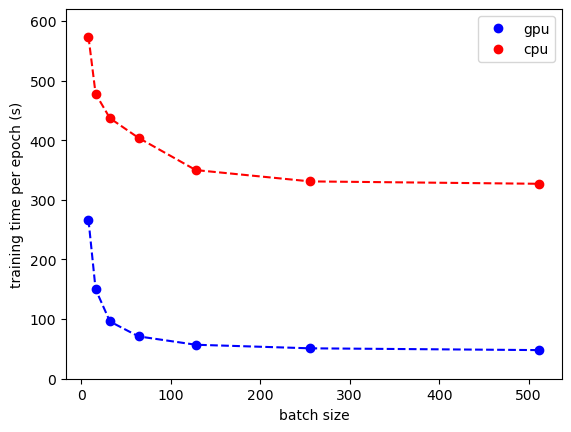

In [8]:
# plot the comparison. The training with gpu is faster by a factor of about 4-6
batch_sizes=[8,16,32,64,128,256,512]
gpu_list=[267,150,96,71,57,51,48]
cpu_list=[574,478,437,404,350,331,327]
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,620])
#plt.savefig('CPUvsGPU.png') 
plt.show()

In [9]:
ratio_list=[j/k for (j, k) in zip(cpu_list,gpu_list)]
ratio_list

[2.149812734082397,
 3.1866666666666665,
 4.552083333333333,
 5.690140845070423,
 6.140350877192983,
 6.490196078431373,
 6.8125]